In [1]:
import nbimporter
import helper_methods as hm
import preprocessing as pp
import numpy as np
import time
from sklearn.neural_network import MLPClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt

Importing Jupyter notebook from helper_methods.ipynb
Importing Jupyter notebook from preprocessing.ipynb


## NN Classifier Implementation

In [2]:
class Neural_Network:
    
    def __init__(self, n_hidden = 2, learning_rate = 0.01, epochs = 10000):
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    # ACTIVATION - Sigmoid Function
    def sig(self, z):
        return 1 / (1 + np.exp(-z))
    
    # Derivative of Sigmoid Function
    def derivativeSig(self, z):
        return self.sig(z) * (1 - self.sig(z))
    
    def initialise_weights_biases(self, X_train, Y_train):
        # Number of input neurons equal the number of input features
        self.n_input = len(X_train[0])
        
        # Need only single output neuron to decide up or down
        self.n_output = 1
        
        xavier_limits = [
            (6 / (self.n_input + self.n_hidden)) ** 0.5,
            (6 / (self.n_hidden + self.n_output)) ** 0.5
        ]
        
        # Initialising weights and biases using Xavier Initialisation
        # Reference: NLP Goldberg
        self.weights = {
#             'h1': np.random.random((self.n_input, self.n_hidden)),
#             'out': np.random.random((self.n_hidden, self.n_output))
            'h1': np.random.uniform(-xavier_limits[0], xavier_limits[0], (self.n_input, self.n_hidden)),
            'out': np.random.uniform(-xavier_limits[1], xavier_limits[1], (self.n_hidden, self.n_output))
        }

        self.biases = {
#             'h1': np.random.random((1, self.n_hidden)),
#             'out': np.random.random((1, self.n_output))
            'h1': np.random.uniform(-xavier_limits[0], xavier_limits[0], (1, self.n_hidden)),
            'out': np.random.uniform(-xavier_limits[1], xavier_limits[1], (1, self.n_output))
        }
    
    # This function trains the network
    def fit(self, X_train, Y_train):
        Y_train[Y_train == -1] = 0
        Y_train = np.expand_dims(Y_train, axis=1)
        self.initialise_weights_biases(X_train, Y_train)
        for iter in range(self.epochs):
            # Forward Propagation
            inputHidden = np.dot(X_train, self.weights['h1']) + self.biases['h1']
            outputHidden = self.sig(inputHidden)
            inputForOutputLayer = np.dot(outputHidden, self.weights['out']) + self.biases['out']
            output = self.sig(inputForOutputLayer)

            # Backpropagation
            first_term_output_layer = output - Y_train
            second_term_output_layer = self.derivativeSig(inputForOutputLayer)
            first_two_output_layer = first_term_output_layer * second_term_output_layer
            
            first_term_hidden_layer = np.dot(first_two_output_layer, self.weights['out'].T)
            second_term_hidden_layer = self.derivativeSig(inputHidden)
            first_two_hidden_layer = first_term_hidden_layer * second_term_hidden_layer

            changes_output = np.dot(outputHidden.T, first_two_output_layer)
            changes_output_bias = np.sum(first_two_output_layer, axis = 0, keepdims = True)

            changes_hidden = np.dot(X_train.T, first_two_hidden_layer)
            changes_hidden_bias = np.sum(first_two_hidden_layer, axis = 0, keepdims = True)

            self.weights['out'] = self.weights['out'] - self.learning_rate*changes_output
            self.biases['out'] = self.biases['out'] - self.learning_rate*changes_output_bias

            self.weights['h1'] = self.weights['h1'] - self.learning_rate*changes_hidden
            self.biases['h1'] = self.biases['h1'] - self.learning_rate*changes_hidden_bias

    def predict(self, X_test):
        inputHidden = np.dot(X_test, self.weights['h1']) + self.biases['h1']
        outputHidden = self.sig(inputHidden)
        inputForOutputLayer = np.dot(outputHidden, self.weights['out']) + self.biases['out']
        predictions = self.sig(inputForOutputLayer)
#         print('Not rounding', np.squeeze(predictions))
        predictions = np.rint(np.squeeze(predictions))
        predictions[predictions == 0] = -1
        return predictions

    def predict_proba(self, X_test):
        inputHidden = np.dot(X_test, self.weights['h1']) + self.biases['h1']
        outputHidden = self.sig(inputHidden)
        inputForOutputLayer = np.dot(outputHidden, self.weights['out']) + self.biases['out']
        predictions = self.sig(inputForOutputLayer)
        prob = []
        for prediction in predictions:
            prob.append([1 - prediction[0], prediction[0]])
        return prob

### Preparing Data / Using CV to find Optimal Parameters

In [3]:
def print_parameters_accuracy(accuracies):
    print('#Features \t C \t Gamma \t Accuracy')
    for i in range(len(accuracies)):
        print(accuracies[i][0], '\t\t', accuracies[i][1], '\t\t', accuracies[i][2], '\t\t', accuracies[i][3])
    print()

In [4]:
def find_optimal_values(max_features, n_hidden_list, lr_list, epochs, num_splits = 10, symbol_name = 'AAPL', use_implementation = True):
    accuracies = list()
    for num_features in range(3, max_features + 1, 2):
        print('Features:', num_features)
        
        X_train, X_test, Y_train, Y_test = hm.prepare_data(num_features, symbol_name, is_binary_ouput=True)
        X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
        
        for n_hidden in n_hidden_list: # [5, 10, 20, 50, 100, 1000, 2000]:
            for lr in lr_list: # [0.0001, 0.0005, 0.001, 0.01, 0.1, 1]:
                print('(n_hidden, lr) ------------------------> (' + str(n_hidden) + ', ' + str(lr) + ')')
                nn_tscv = Neural_Network(n_hidden=n_hidden, learning_rate=lr, epochs=epochs)
                if use_implementation:
                    accuracy = hm.timeSeriesCV(X_train, Y_train, num_splits, nn_tscv, is_classification=True)
                else:
                    accuracy = hm.rolling_cross_validation(X_train, Y_train, num_splits, nn_tscv, is_classification=True)
                accuracies.append([num_features, n_hidden, lr, accuracy])
    
    print_parameters_accuracy(accuracies)
    
    # Sorting the accuracies
    accuracies.sort(reverse=True, key=lambda x: x[len(accuracies) - 1])
    print_parameters_accuracy(accuracies)
    
    return accuracies[0][0], accuracies[0][1], accuracies[0][2]

In [5]:
def get_data_ready(symbol_name, max_features, n_hidden_list, lr_list, epochs):
    start_time = time.time()
    num_features, n_hidden, learning_rate = find_optimal_values(max_features, n_hidden_list, lr_list, epochs, num_splits=10, symbol_name = symbol_name)
    end_time = time.time()
    print('Time taken for Cross Validation:', end_time - start_time)
    
    X_train, X_test, Y_train, Y_test = hm.prepare_data(max_features, symbol_name=symbol_name)
    X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
    return X_train, X_test, Y_train, Y_test, n_hidden, learning_rate

### 1. SKLearn NN Classifier

In [6]:
def sklearn_MLP_forecast(X_train, X_test, Y_train, Y_test, n_hidden = 2, learning_rate = 0.01, epochs = 200):
    print('SKLEARN INBUILT')
    clf = MLPClassifier(max_iter=epochs, hidden_layer_sizes=(n_hidden))
    clf.fit(X_train, Y_train)
    print('Predictions: ', clf.predict(X_test))
    hm.accuracy_metrics(Y_test, clf.predict(X_test))
    print('Accuracy Score --', clf.score(X_test, Y_test), '\n\n')
    
    y_pred_proba = clf.predict_proba(X_test)
    skplt.metrics.plot_roc_curve(Y_test, y_pred_proba)
    plt.show()

### 2. Implementation Classifier

ROC Curve: https://stackoverflow.com/a/42392458/6001624

In [7]:
def implemented_NN_forecast(X_train, X_test, Y_train, Y_test, n_hidden = 2, learning_rate = 0.01, epochs = 200):
    nn = Neural_Network(n_hidden=n_hidden, learning_rate=learning_rate, epochs=epochs)
    nn.fit(X_train, Y_train)
    
    print('IMPLEMENTATION') 
    Y_pred = nn.predict(X_test)
    hm.accuracy_metrics(Y_test, Y_pred)
    
    y_pred_proba = nn.predict_proba(X_test)
    skplt.metrics.plot_roc_curve(Y_test, y_pred_proba)
    plt.show()

### Running NN

In [8]:
def forecast(X_train, X_test, Y_train, Y_test, n_hidden = 2, learning_rate = 0.01, epochs = 200):
    print('Number of Hidden Neurons --', n_hidden)
    print('Learning Rate --', learning_rate)
    print('Number of Epochs --', epochs, '\n\n')
    sklearn_MLP_forecast(X_train, X_test, Y_train, Y_test, n_hidden, learning_rate, epochs)
    implemented_NN_forecast(X_train, X_test, Y_train, Y_test, n_hidden, learning_rate, epochs)

In [9]:
def run_NN(symbol_name):
    max_features = 10
    epochs = 10000 # can plot the error against epochs to see the ideal number of epochs
    # Reference: Number of hidden neurons : https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    n_hidden_list = [5, 10, 20, 50, 100] #, 1000, 2000]
    lr_list = [0.0001, 0.0005, 0.001] # 0.01, 0.1, 1]
    
    X_train, X_test, Y_train, Y_test, n_hidden, learning_rate = get_data_ready(symbol_name, max_features, n_hidden_list, lr_list, epochs)
    forecast(X_train, X_test, Y_train, Y_test, n_hidden, learning_rate, epochs)

Features: 3
(n_hidden, lr) ------------------------> (5, 0.0001)
Implemented Rolling Cross Validation
Accuracy: 0.4997165532879818 

(n_hidden, lr) ------------------------> (5, 0.0005)
Implemented Rolling Cross Validation
Accuracy: 0.4994331065759636 

(n_hidden, lr) ------------------------> (5, 0.001)
Implemented Rolling Cross Validation
Accuracy: 0.4997165532879818 

(n_hidden, lr) ------------------------> (10, 0.0001)
Implemented Rolling Cross Validation
Accuracy: 0.4997165532879818 

(n_hidden, lr) ------------------------> (10, 0.0005)
Implemented Rolling Cross Validation
Accuracy: 0.4931972789115646 

(n_hidden, lr) ------------------------> (10, 0.001)
Implemented Rolling Cross Validation
Accuracy: 0.4977324263038548 

(n_hidden, lr) ------------------------> (20, 0.0001)
Implemented Rolling Cross Validation
Accuracy: 0.5 

(n_hidden, lr) ------------------------> (20, 0.0005)
Implemented Rolling Cross Validation
Accuracy: 0.4997165532879818 

(n_hidden, lr) -----------------

Number of Hidden Neurons -- 5
Learning Rate -- 0.0001
Number of Epochs -- 10000 


SKLEARN INBUILT
Predictions:  [ 1.  1. -1. ...  1. -1.  1.]
Accuracy: 0.47396630934150075
Matthews Correlation Coefficient: -0.05841847573823512
Confustion Matrix
[[212 432]
 [255 407]]
Classification Report
             precision    recall  f1-score   support

       -1.0       0.45      0.33      0.38       644
        1.0       0.49      0.61      0.54       662

avg / total       0.47      0.47      0.46      1306

Accuracy Score -- 0.47396630934150075 




/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


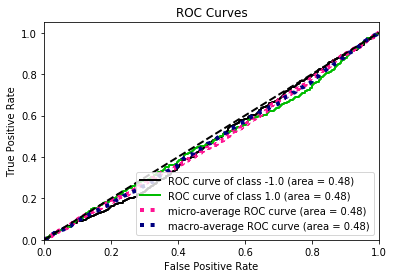

IMPLEMENTATION
Accuracy: 0.49310872894333846
Matthews Correlation Coefficient: -0.007135205894923079
Confustion Matrix
[[506 138]
 [524 138]]
Classification Report
             precision    recall  f1-score   support

       -1.0       0.49      0.79      0.60       644
        1.0       0.50      0.21      0.29       662

avg / total       0.50      0.49      0.45      1306



/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


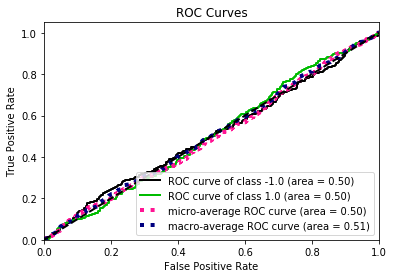

In [10]:
run_NN(symbol_name = 'AAPL')